In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [ ]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

# import lightgbm as lgb
# import xgboost as xgb
import catboost
from catboost import CatBoostRegressor


pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
pcp_df = pd.read_csv("to_predict.csv")
cl_df = pd.read_csv("CLdata.csv")
bs_df = pd.read_csv("BSinfo.csv")
ec_df  = pd.read_csv("ECdata.csv")
ss_df = pd.read_csv("SampleSubmission.csv")

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

((26139, 4), (125575, 10), (1217, 8), (92629, 3), (26139, 2))

In [ ]:
ec_df.head()


,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [ ]:
cl_df.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
bs_df.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [ ]:
pcp_df.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


In [ ]:
pcp_df['w'].value_counts()

1    23189
5     2950
Name: w, dtype: int64

In [ ]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [ ]:
pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

In [ ]:
cl_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
bs_df.head()

,bs,cellname,rutype,mode,frequency,bandwidth,antennas,txpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [ ]:
ec_df.head()

,time,bs,energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [ ]:
pcp_df.head()

,time,bs,energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


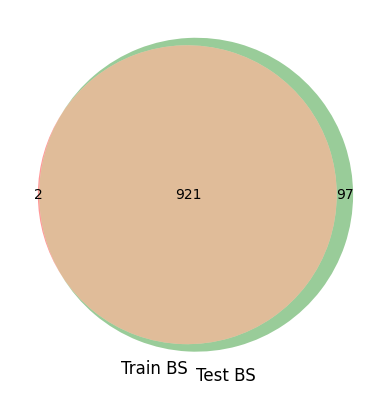

In [ ]:
train_bs_set = set(ec_df['bs'].values.tolist())
test_bs_set = set(pcp_df['bs'].values.tolist())

venn2([train_bs_set, test_bs_set], ('Train BS', 'Test BS'))
plt.show()

In [ ]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [ ]:
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
cl_bs_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [ ]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504


In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique()

bs
B_0       2
B_1       1
B_10      2
B_100     1
B_1000    1
         ..
B_995     1
B_996     1
B_997     1
B_998     1
B_999     1
Name: cellname, Length: 1020, dtype: int64

In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

1    827
2    191
4      2
Name: cellname, dtype: int64

In [ ]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [ ]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

In [ ]:
cl_bs_df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2


In [ ]:
cl_bs_df.describe()

,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3
count,118768.000000,6711.000000,48.000000,48.000000,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.0,6711.0,48.0,48.0,118768.000000,6711.0,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.00,48.00,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.000000,48.000000
mean,0.246362,0.111214,0.070212,0.081115,0.042145,0.004985,0.0,0.0,0.038640,0.003311,0.0,0.0,0.000082,0.000135,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.0,0.0,0.019168,0.386253,0.0,0.0,373.152776,379.542459,426.98,426.98,16.323740,6.338251,2.0,2.0,2.493079,2.218149,2.0,2.0,6.728786,7.028953,6.877429,6.877429
std,0.239354,0.091569,0.023807,0.038373,0.194184,0.064911,0.0,0.0,0.186785,0.052831,0.0,0.0,0.002439,0.002422,0.0,0.0,0.0,0.0,0.0,0.0,0.002882,0.0,0.0,0.0,0.112214,0.395205,0.0,0.0,145.409519,102.348829,0.00,0.00,5.238965,6.209317,0.0,0.0,4.617650,0.755766,0.0,0.0,0.330830,0.386024,0.000000,0.000000
min,0.000000,0.008190,0.045942,0.045904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,155.600000,155.600000,426.98,426.98,2.000000,2.000000,2.0,2.0,1.000000,1.000000,2.0,2.0,5.381166,6.427504,6.877429,6.877429
25%,0.055714,0.051894,0.054442,0.051822,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,189.000000,365.000000,426.98,426.98,10.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.427504,6.761584,6.877429,6.877429
50%,0.162470,0.079423,0.066760,0.067856,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.275973,0.0,0.0,365.000000,426.980000,426.98,426.98,20.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
75%,0.367142,0.138202,0.079385,0.095495,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.803992,0.0,0.0,532.000000,426.980000,426.98,426.98,20.000000,10.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
max,0.993957,0.891770,0.174846,0.196519,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.154563,0.062805,0.0,0.0,0.0,0.0,0.0,0.0,0.768070,0.0,0.0,0.0,0.931032,0.927924,0.0,0.0,979.998000,697.002000,426.98,426.98,20.000000,20.000000,2.0,2.0,64.000000,8.000000,2.0,2.0,8.375336,7.877728,6.877429,6.877429


In [ ]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [ ]:
df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

In [ ]:
df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,30.343797
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,NaN
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,15.545590


In [ ]:
df['energy'].isna().value_counts()

False    92629
True     26139
Name: energy, dtype: int64

New column named 'split' in the DataFrame df. This column will contain the values 'test' for rows where the 'energy' column is NaN and 'train' for rows where the 'energy' column is not NaN.



In [ ]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

In [ ]:
ss_df.shape

(26139, 2)

In [ ]:
ec_df.shape

(92629, 3)

In [ ]:
df['energy'].describe()

count    92629.000000
mean        28.138997
std         13.934645
min          0.747384
25%         18.236173
50%         24.065770
75%         35.724963
max        100.000000
Name: energy, dtype: float64

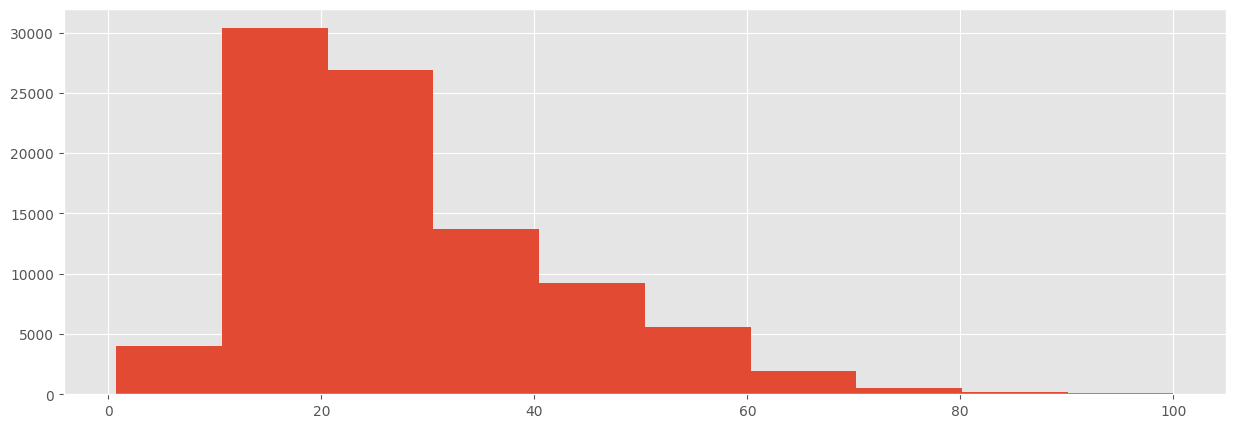

In [ ]:
plt.figure(figsize=(15, 5))
df['energy'].hist()
plt.show()

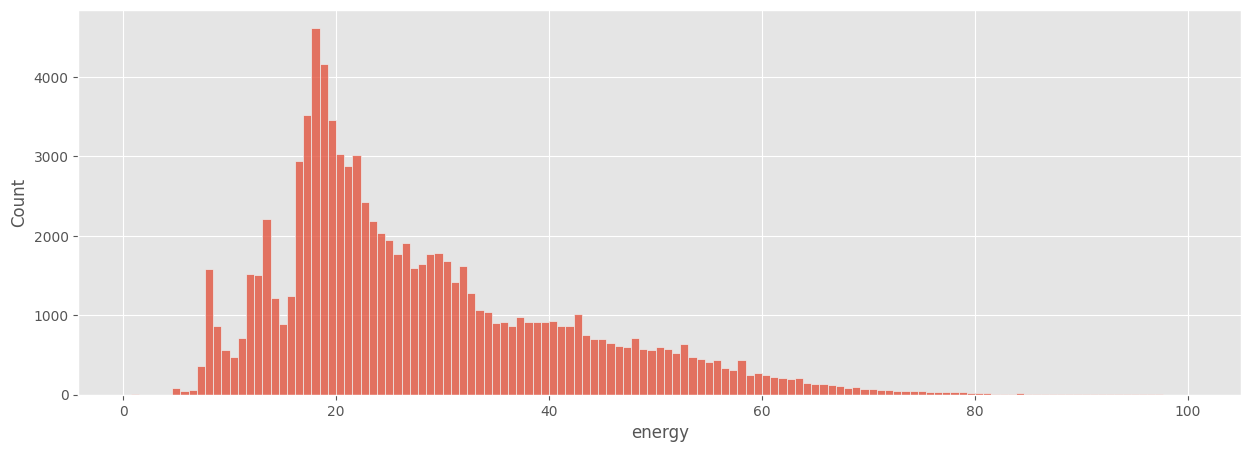

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'])
plt.show()

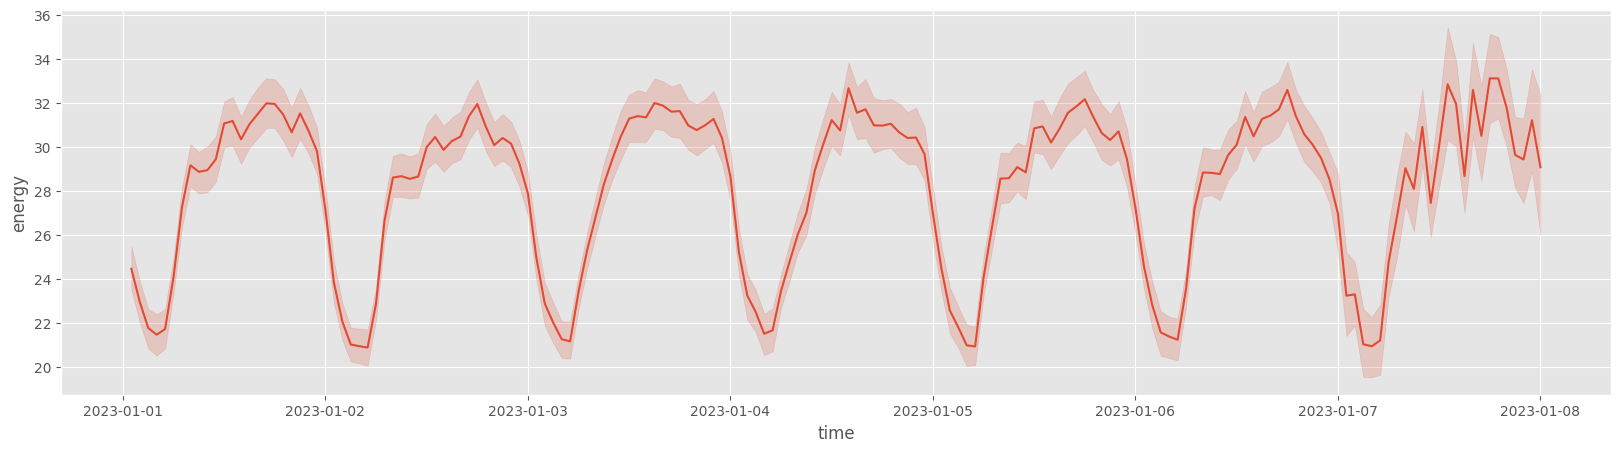

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy')
plt.show()

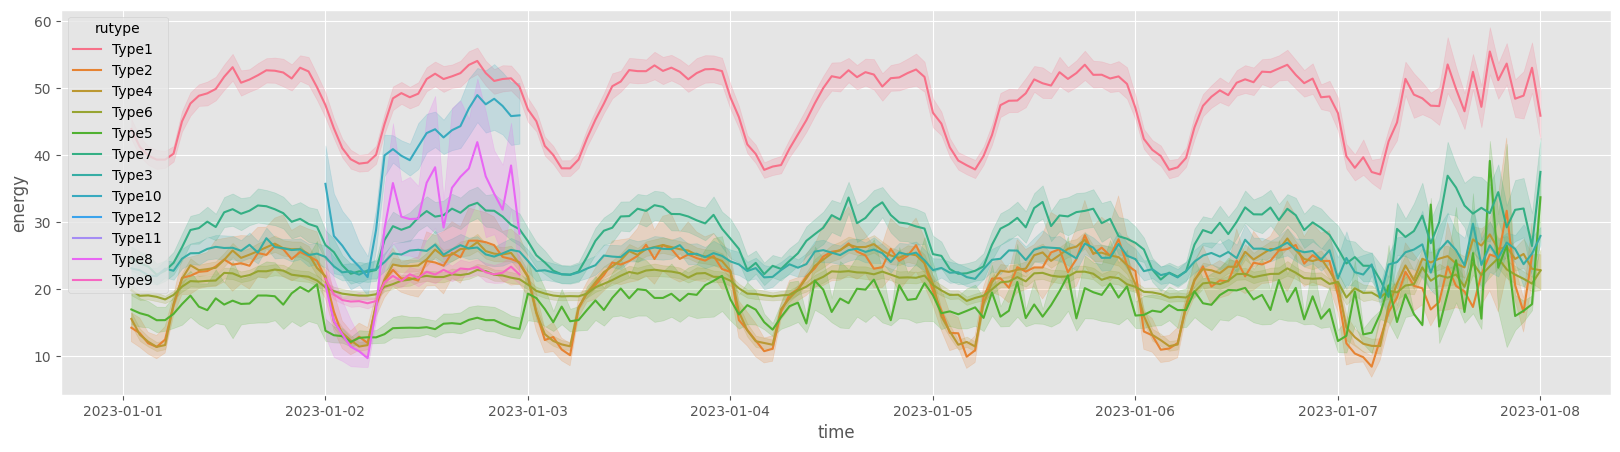

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='rutype')
plt.show()

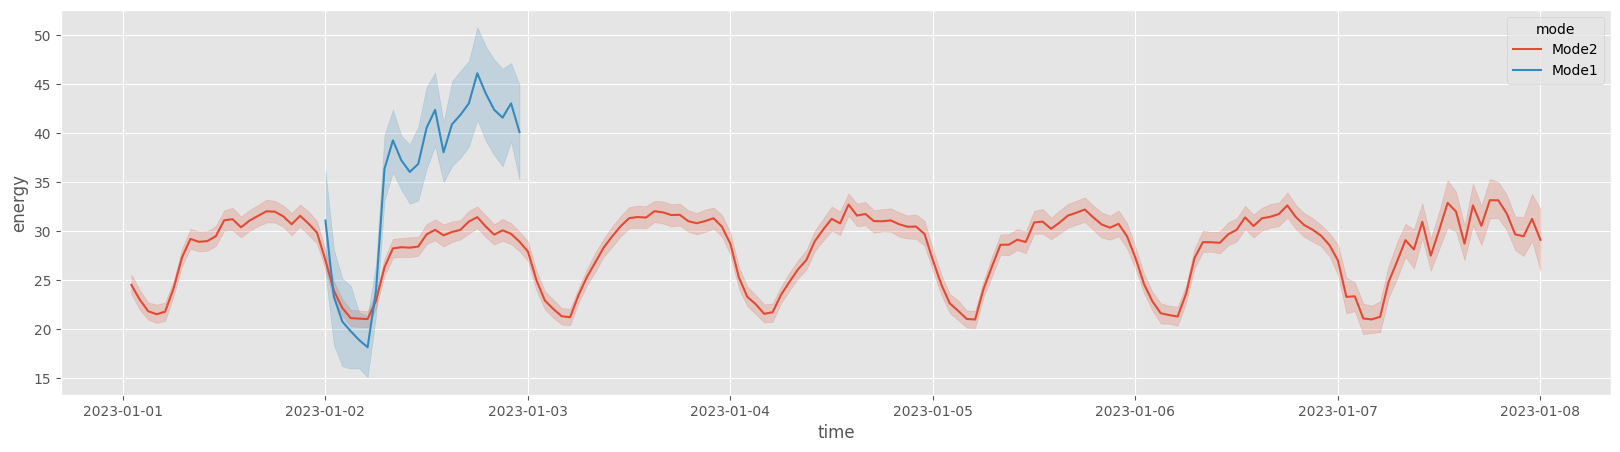

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='mode')
plt.show()

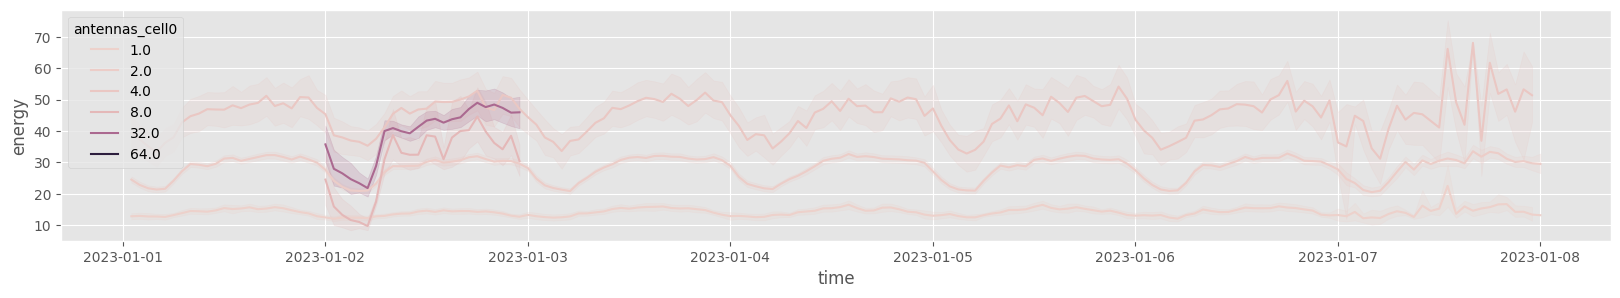

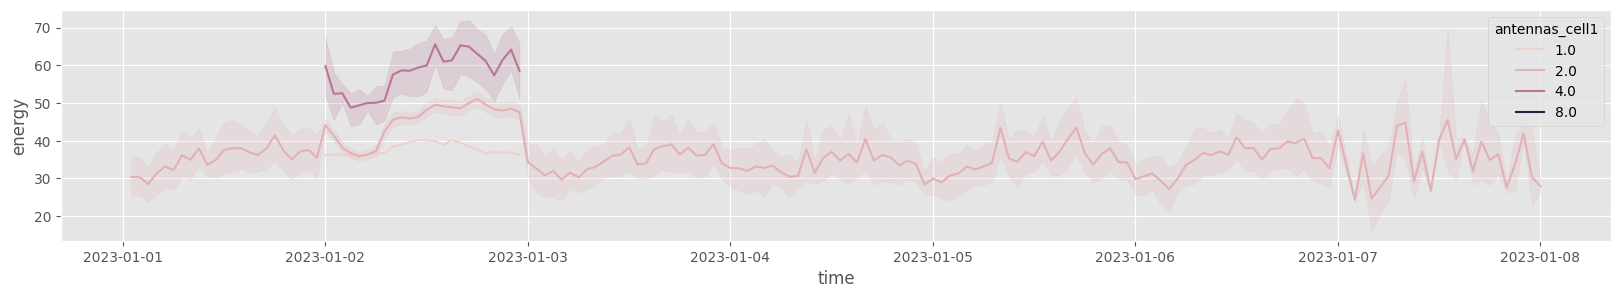

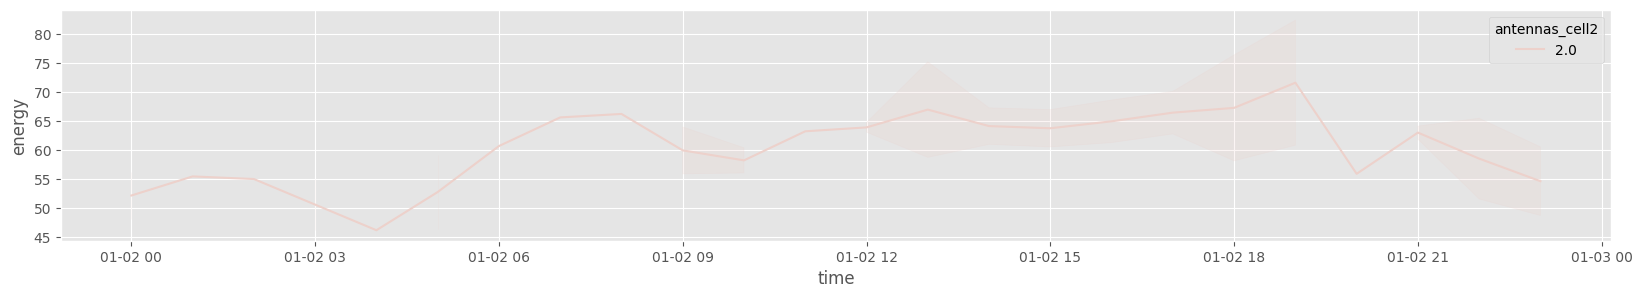

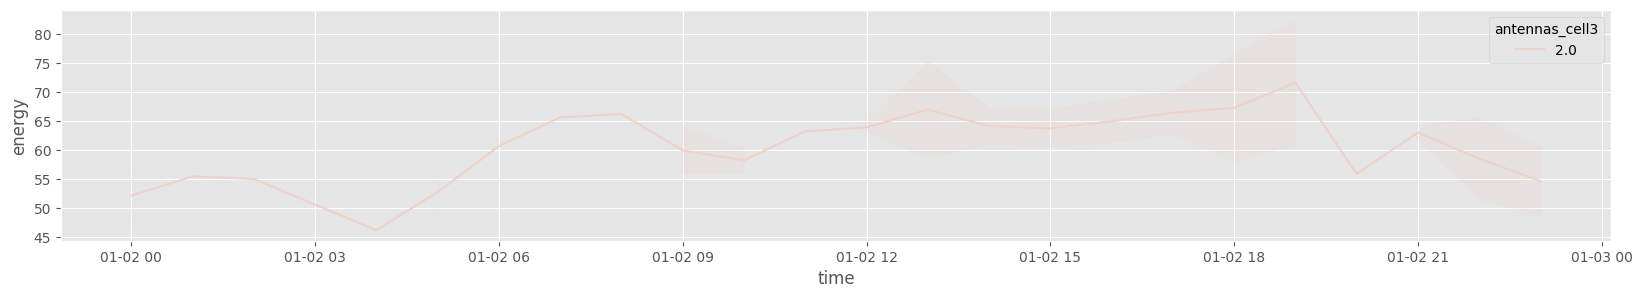

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell3')
plt.show()

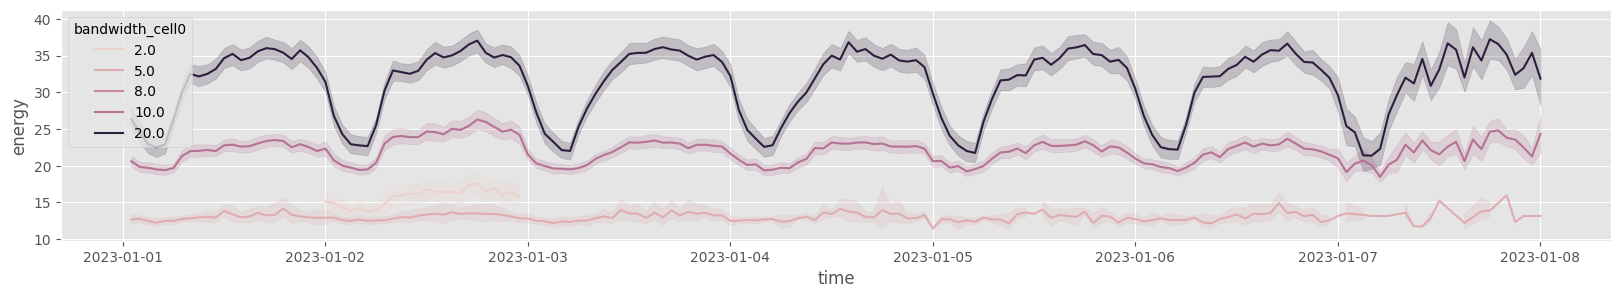

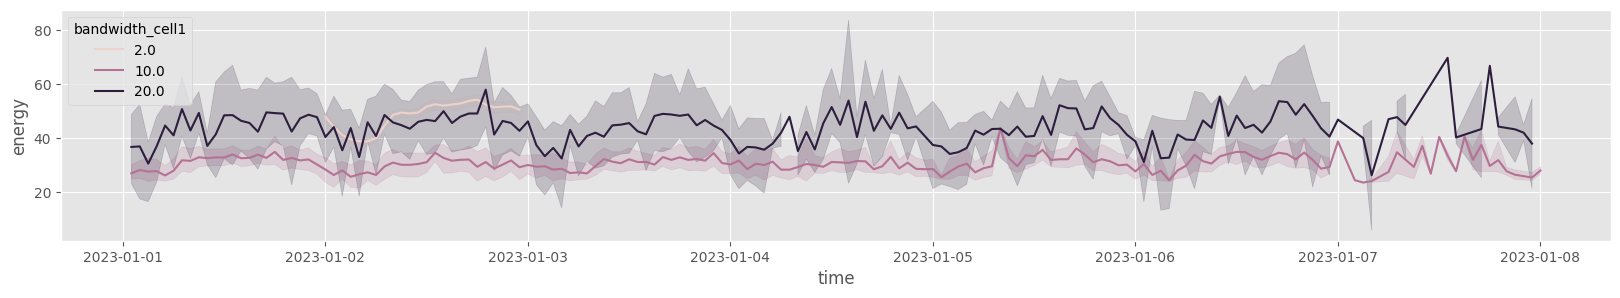

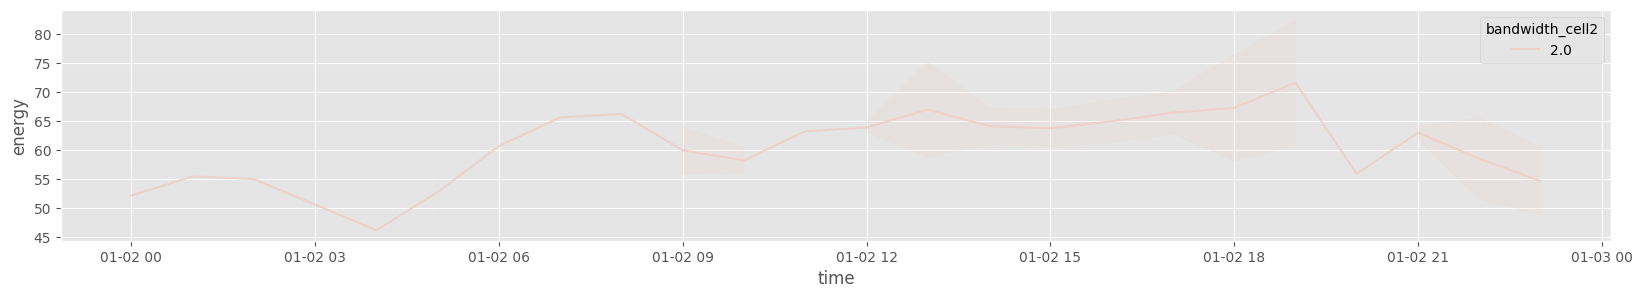

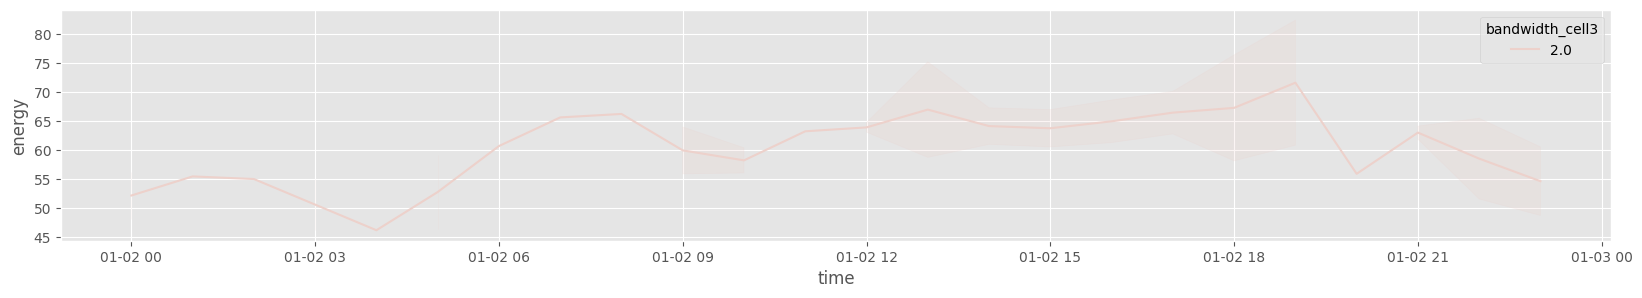

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell3')
plt.show()

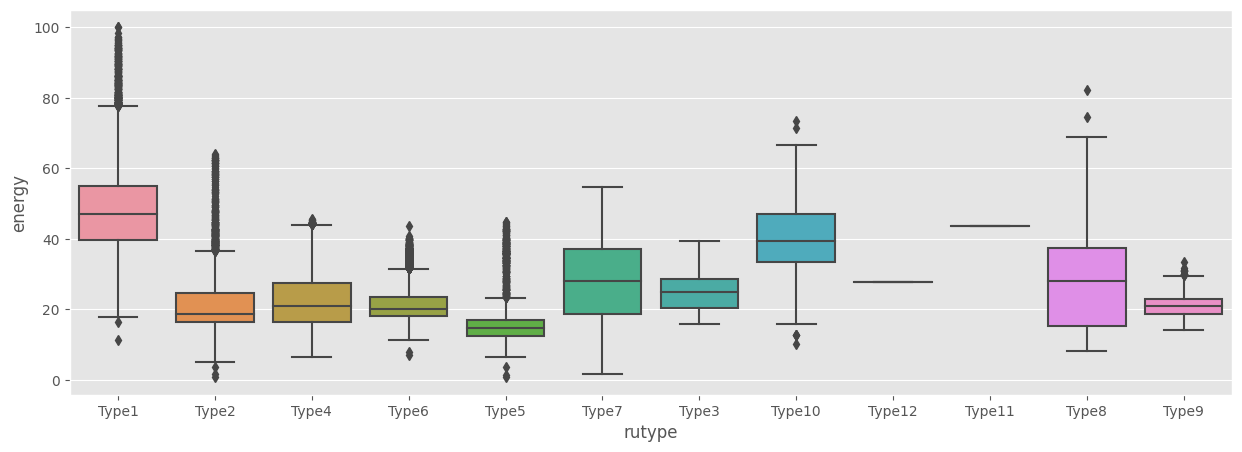

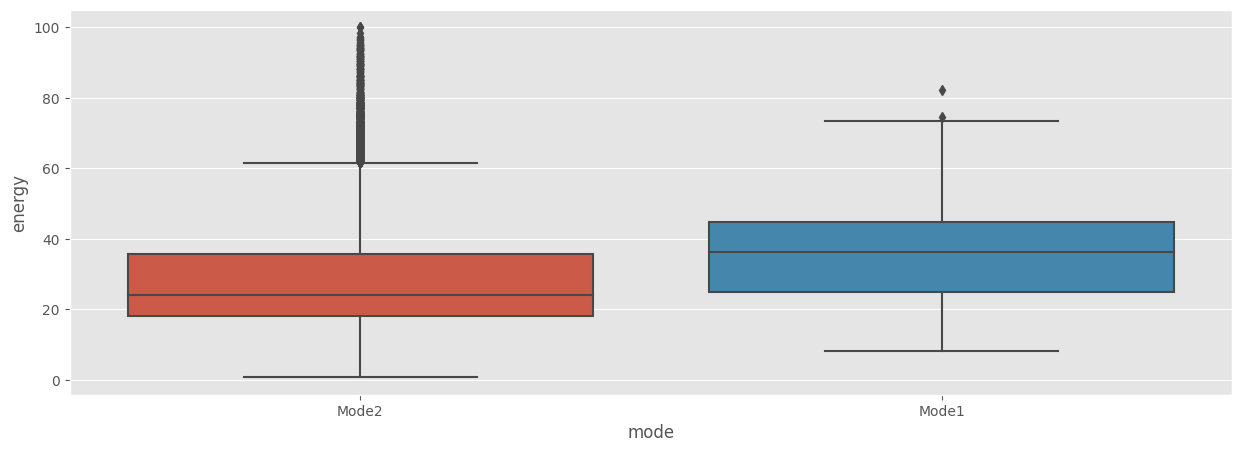

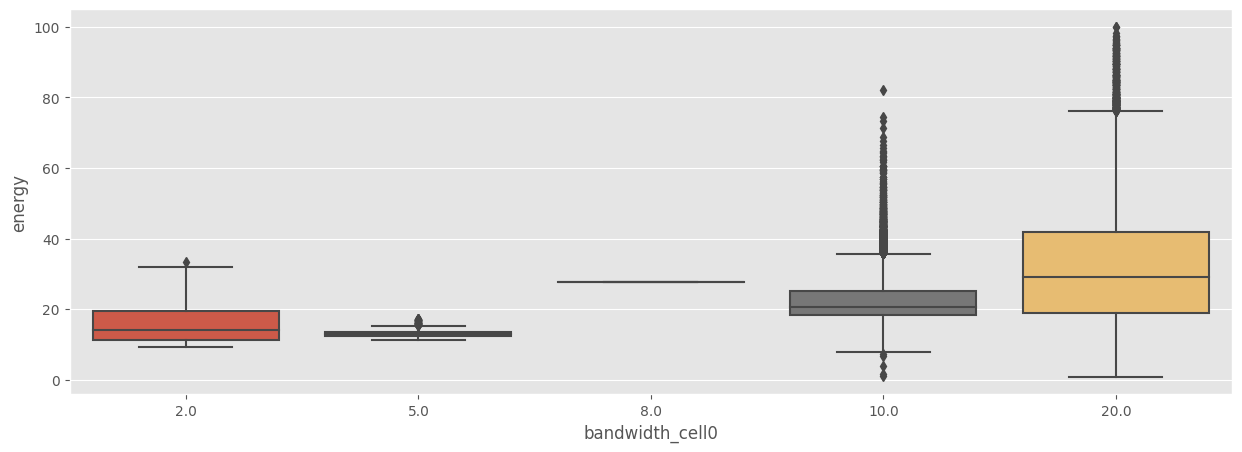

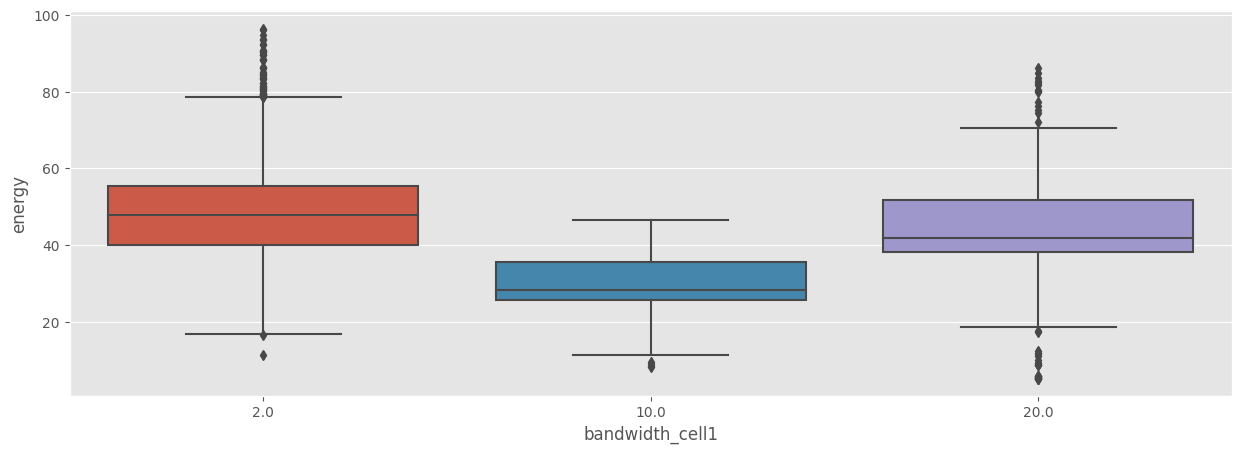

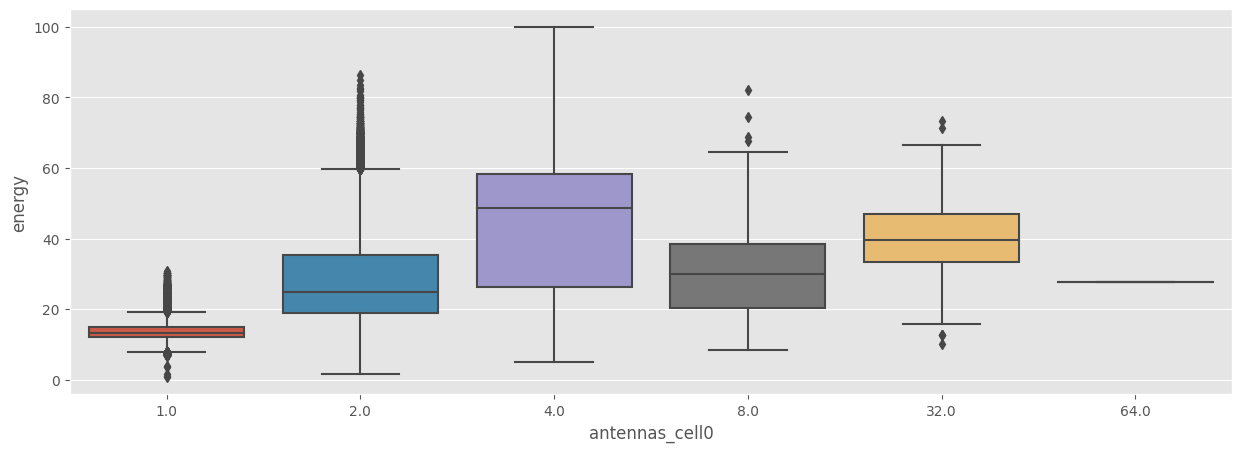

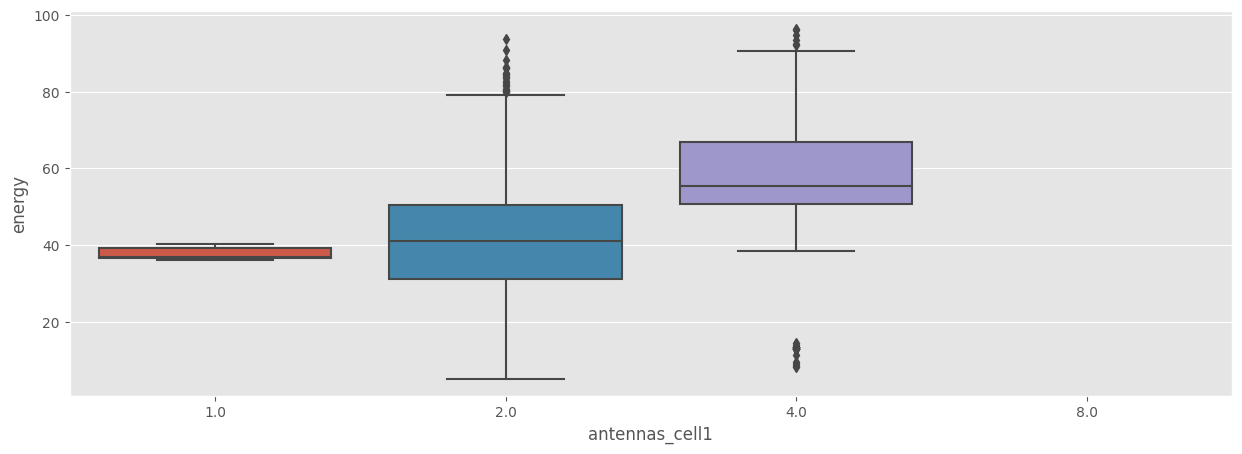

In [ ]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df, x=fe, y='energy')
    plt.show()

In [ ]:
def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.countplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name)
    axes[0].set_title('Train Count Plot')

    # Plot the box plot on the second subplot
    sns.countplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name)
    axes[1].set_title('Test Count Plot')

    sns.countplot(data=df, ax=axes[2], x=fe_name, hue='split')
    axes[2].set_title('Train & Test Count Plot')

    plt.show()

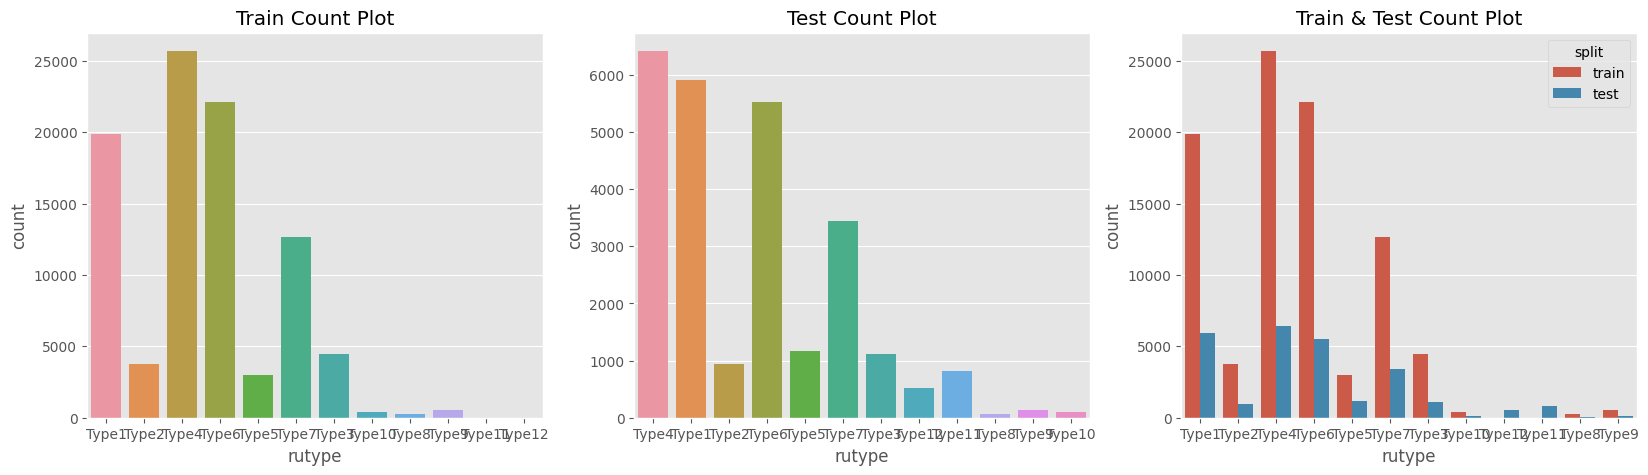

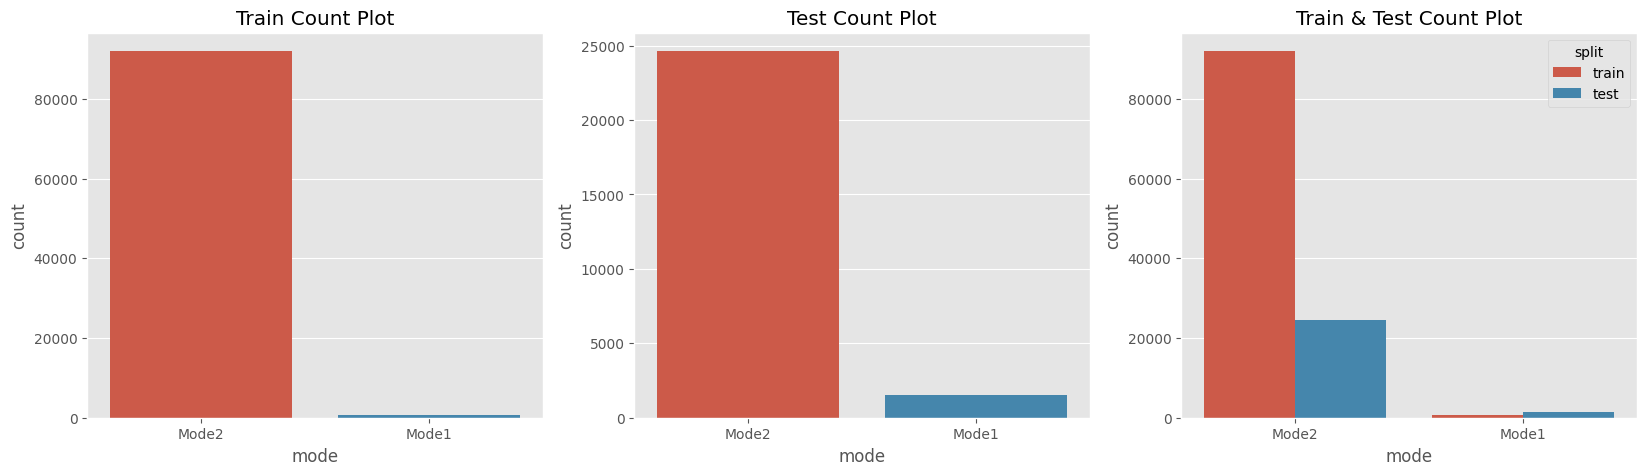

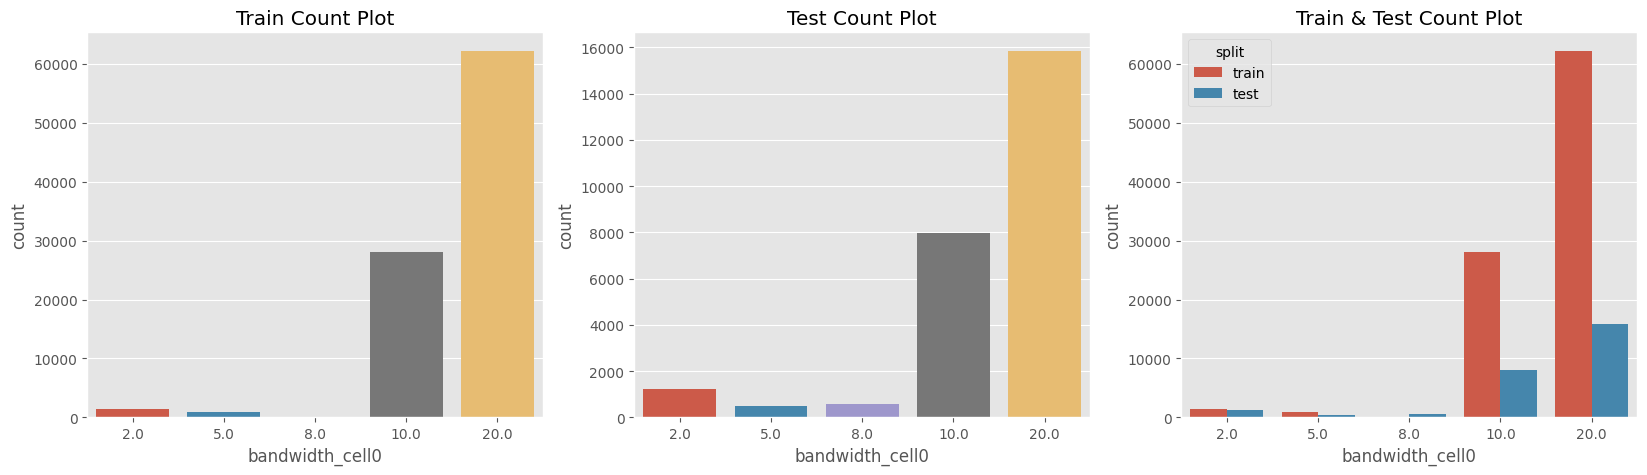

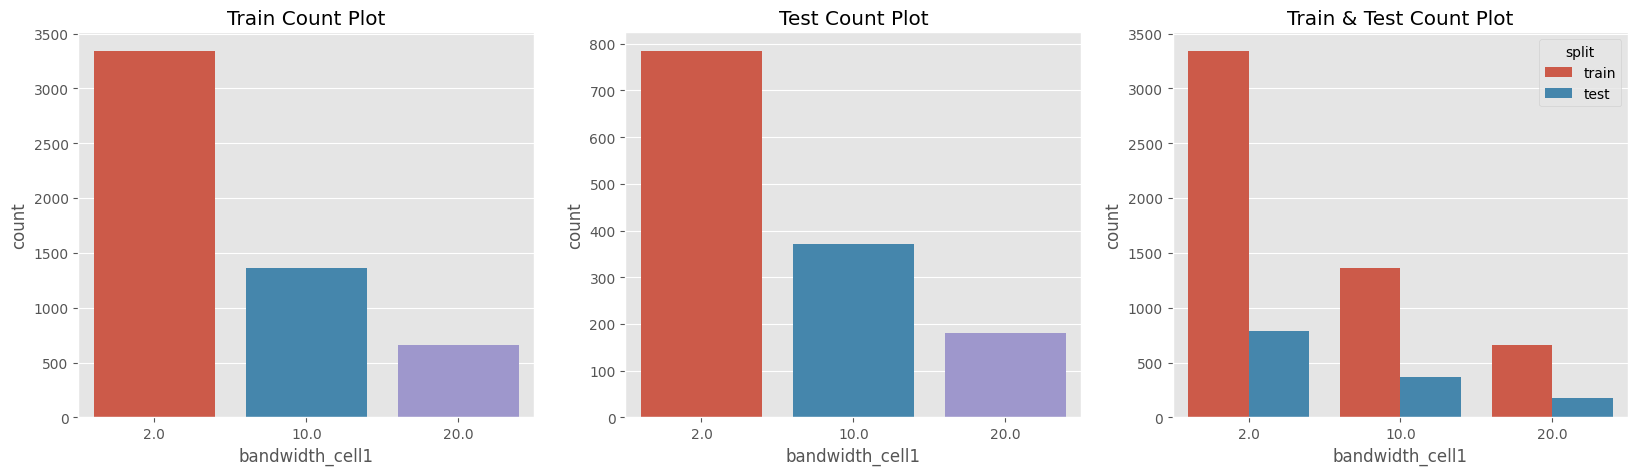

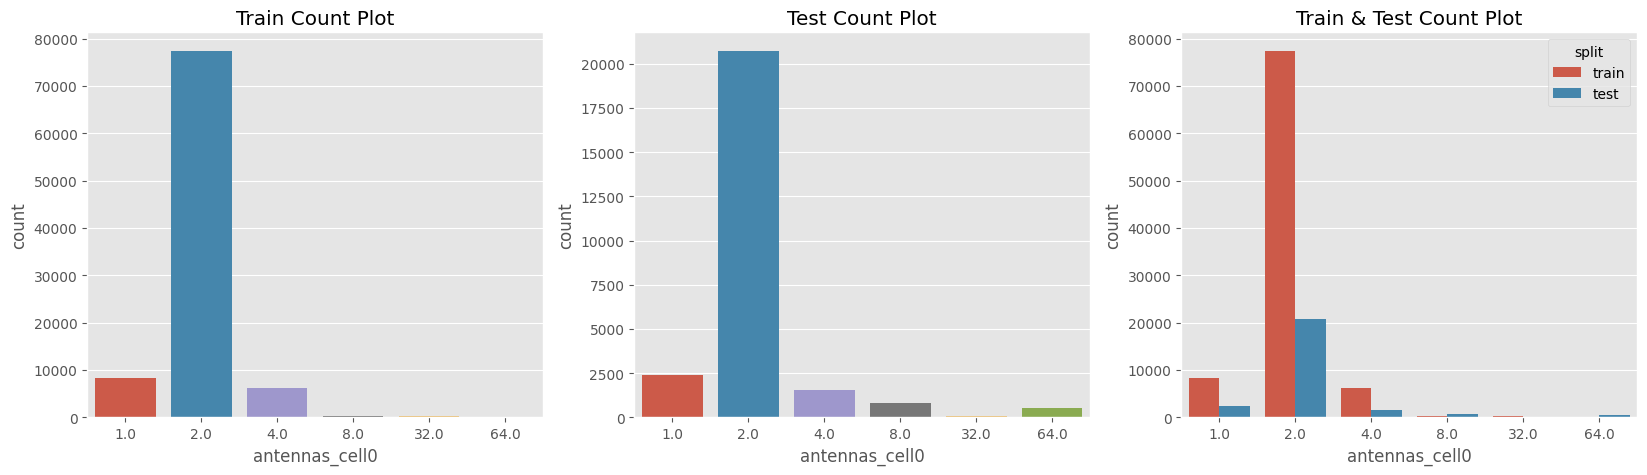

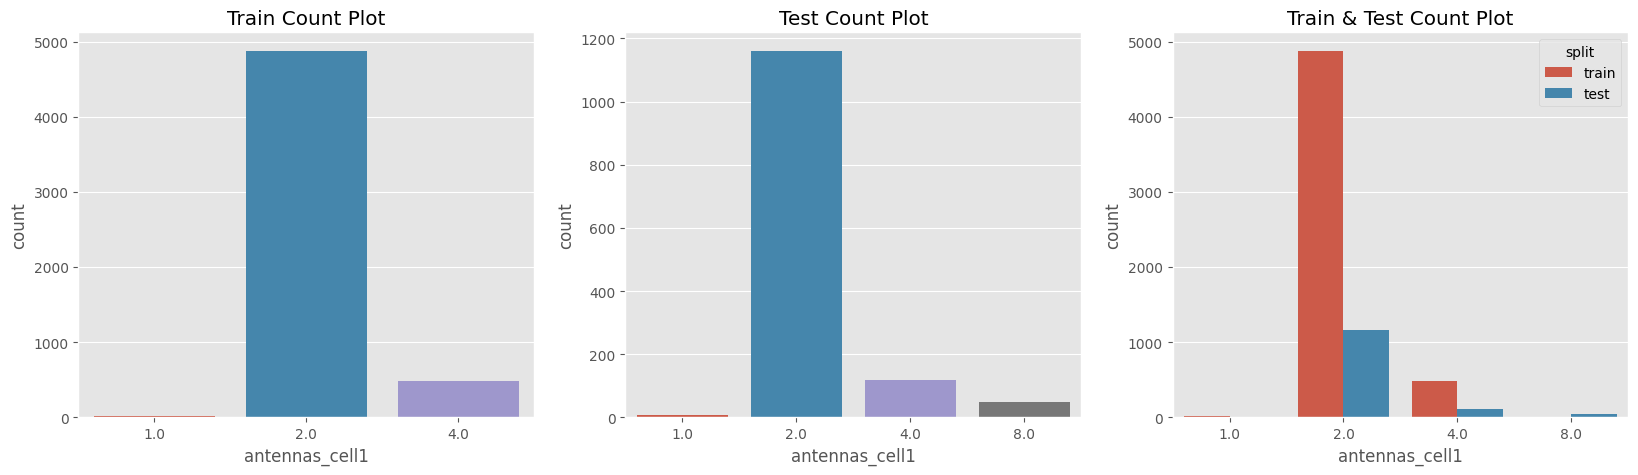

In [ ]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plot_cat_train_test_dist(df=df, fe_name=fe, hue='split')

In [ ]:
df.groupby("split")['rutype'].value_counts().sort_index()

split  rutype
test   Type1      5908
       Type10      101
       Type11      815
       Type12      527
       Type2       939
       Type3      1111
       Type4      6419
       Type5      1164
       Type6      5521
       Type7      3446
       Type8        58
       Type9       130
train  Type1     19902
       Type10      403
       Type11        1
       Type12        1
       Type2      3757
       Type3      4442
       Type4     25677
       Type5      2974
       Type6     22083
       Type7     12641
       Type8       230
       Type9       518
Name: rutype, dtype: int64

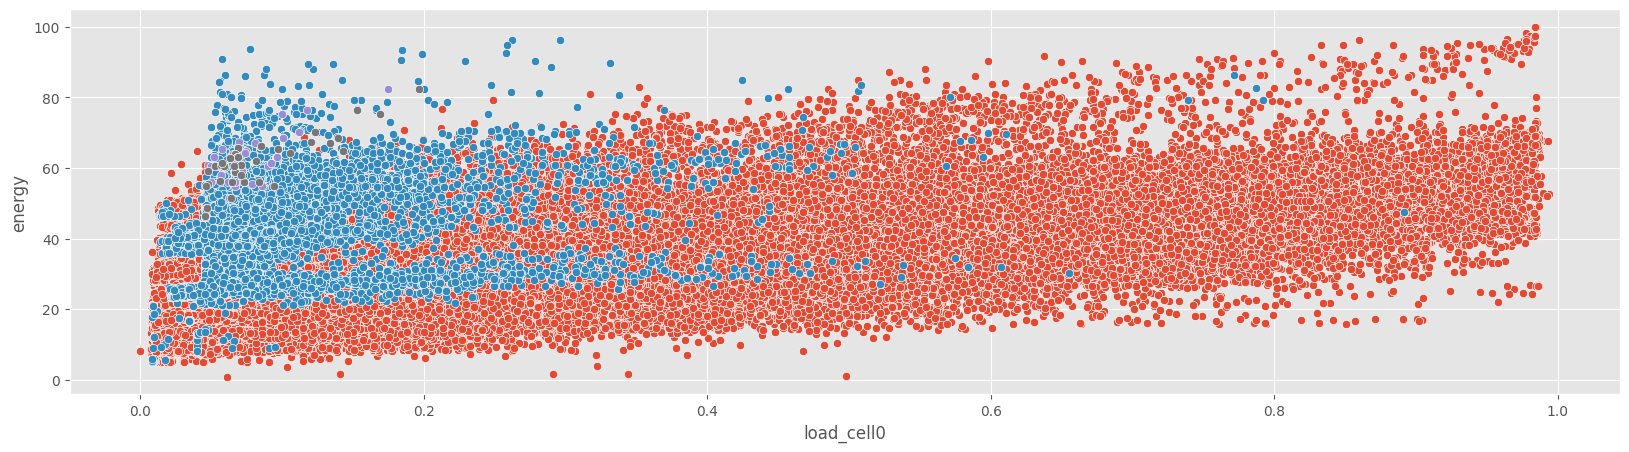

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell3', y='energy')
plt.show()

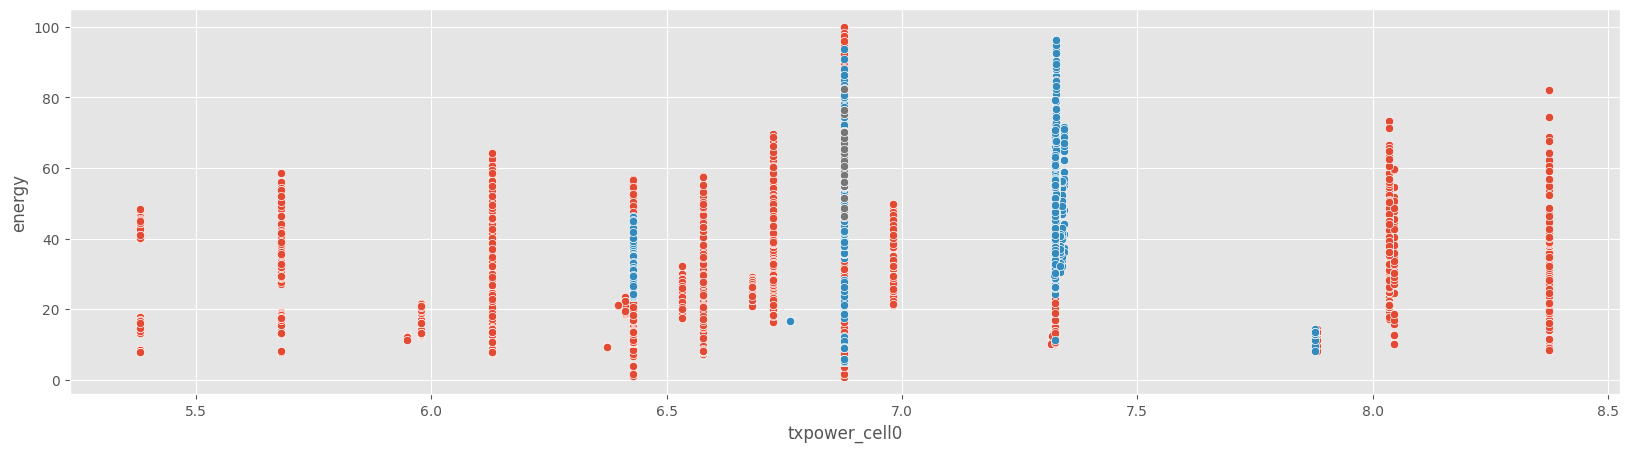

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell3', y='energy')
plt.show()

In [ ]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 50), (26139, 50))

In [ ]:
def feature_enginning(train_df, valid_df, test_df):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))


    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)


    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

In [ ]:
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

In [ ]:
# Energy usage by number of cells in use
cell_count_energy = df.groupby('antennas_cell0')['energy'].mean()
print(cell_count_energy)


antennas_cell0
1.0     14.084051
2.0     28.260433
4.0     45.006119
8.0     29.876239
32.0    39.076137
64.0    27.653214
Name: energy, dtype: float64


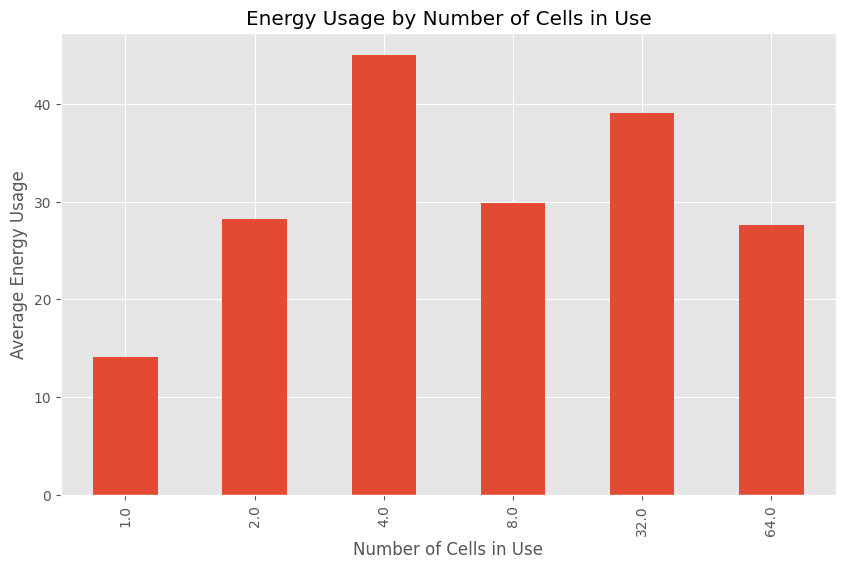

In [ ]:
import matplotlib.pyplot as plt

# Energy usage by number of cells in use
cell_count_energy = df.groupby('antennas_cell0')['energy'].mean()
cell_count_energy.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Number of Cells in Use')
plt.ylabel('Average Energy Usage')
plt.title('Energy Usage by Number of Cells in Use')
plt.show()


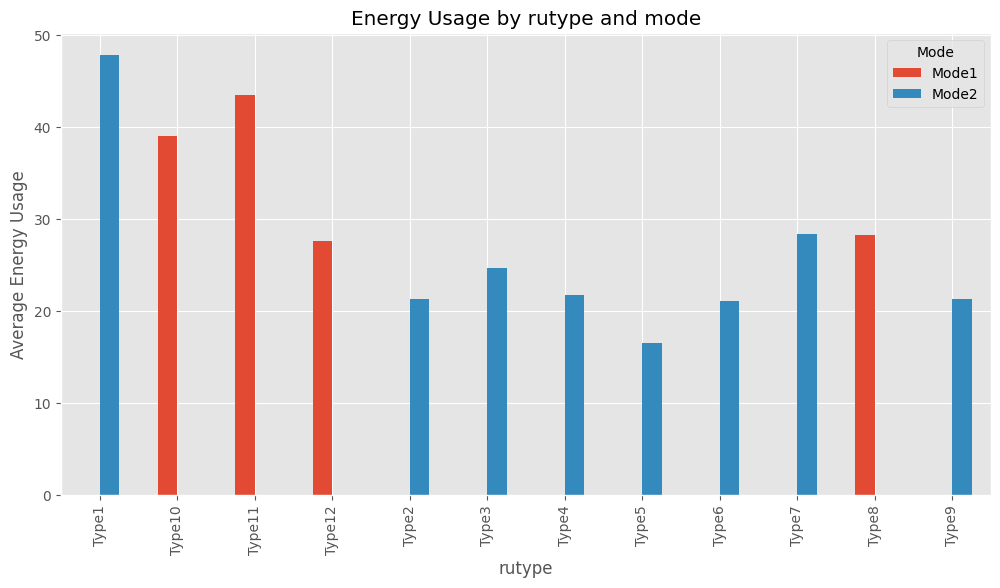

In [ ]:
import seaborn as sns

# Energy usage by rutype and mode
rutype_mode_energy = df.groupby(['rutype', 'mode'])['energy'].mean().unstack()
rutype_mode_energy.plot(kind='bar', figsize=(12, 6))
plt.xlabel('rutype')
plt.ylabel('Average Energy Usage')
plt.title('Energy Usage by rutype and mode')
plt.legend(title='Mode')
plt.show()


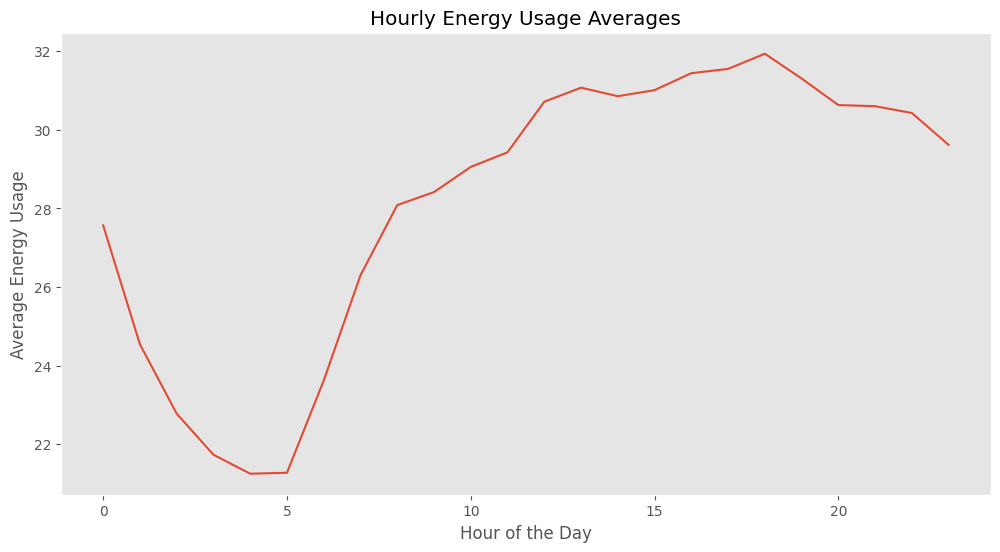

In [ ]:
# Hourly energy usage averages
hourly_energy = df.groupby(df['time'].dt.hour)['energy'].mean()
hourly_energy.plot(kind='line', figsize=(12, 6))
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Usage')
plt.title('Hourly Energy Usage Averages')
plt.grid()
plt.show()


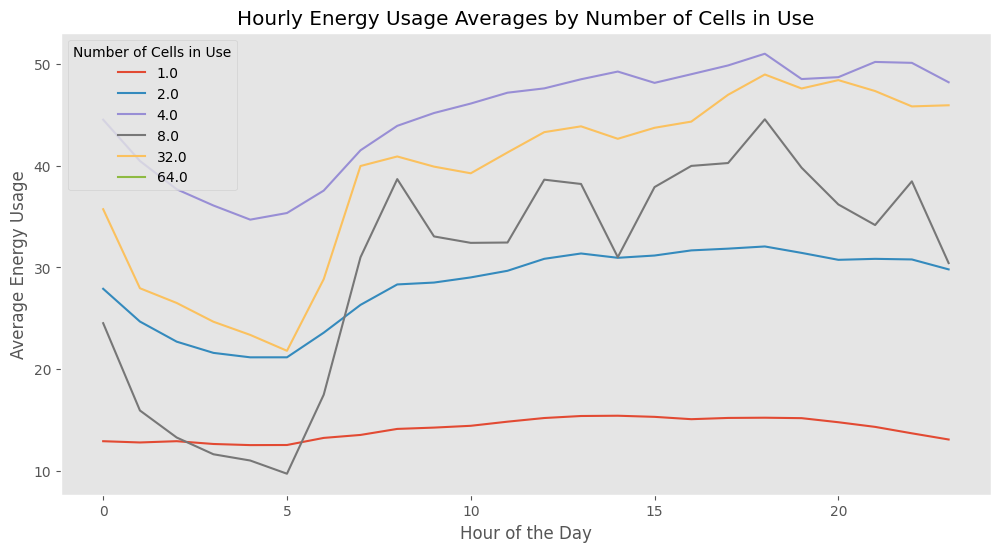

In [ ]:
import seaborn as sns

# Hourly energy usage averages by number of cells in use
hourly_cell_count_energy = df.groupby([df['time'].dt.hour, 'antennas_cell0'])['energy'].mean().unstack()
hourly_cell_count_energy.plot(kind='line', figsize=(12, 6))
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Usage')
plt.title('Hourly Energy Usage Averages by Number of Cells in Use')
plt.legend(title='Number of Cells in Use')
plt.grid()
plt.show()


In [59]:
import matplotlib.pyplot as plt

# Group by base station (BS) and cellName to count the number of cells in each BS
bs_cell_count = df.groupby(['bs', 'CellName'])['energy'].mean().reset_index()

# Now, you can plot the average energy usage by the number of cells in each BS
bs_cell_count = bs_cell_count.groupby('bs')['energy'].mean()
bs_cell_count.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Base Station (BS)')
plt.ylabel('Average Energy Usage')
plt.title('Energy Usage by Number of Cells in Each Base Station')
plt.show()


KeyError: ignored

In [ ]:
kf = model_selection.KFold(n_splits=10)
kf = kf.split(X=train_data)

oof_valid_preds = np.zeros(train_data.shape[0])
test_preds_list = []

for i, (train_idx, valid_idx) in enumerate(kf):

    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df, valid_df, test_df = feature_enginning(train_df=train_df, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    X_train, y_train = train_df[train_cols], train_df[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    params = {
        'iterations': 10000,
        'learning_rate': 0.1,
        'depth': 6,
        'loss_function': 'MAE',
        'verbose': 100,
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=100,
        verbose=100,
    )

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds[valid_idx] = valid_preds
    test_preds_list.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ", val_score)

oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
print("_-*"*50)
print(f"OOF score : ", oof_score)


0:	learn: 9.8337178	test: 9.4435267	best: 9.4435267 (0)	total: 72.7ms	remaining: 12m 6s
100:	learn: 2.5691593	test: 2.6560298	best: 2.6560298 (100)	total: 2.19s	remaining: 3m 34s
200:	learn: 2.2812959	test: 2.3761070	best: 2.3761070 (200)	total: 4.41s	remaining: 3m 35s
300:	learn: 2.1105561	test: 2.2075630	best: 2.2075630 (300)	total: 6.5s	remaining: 3m 29s
400:	learn: 1.9834725	test: 2.0851572	best: 2.0851572 (400)	total: 10s	remaining: 3m 59s
500:	learn: 1.8775384	test: 1.9775256	best: 1.9775256 (500)	total: 12.1s	remaining: 3m 50s
600:	learn: 1.8050118	test: 1.9057397	best: 1.9057397 (600)	total: 14.3s	remaining: 3m 43s
700:	learn: 1.7486244	test: 1.8498058	best: 1.8498058 (700)	total: 16.4s	remaining: 3m 37s
800:	learn: 1.6932247	test: 1.7953150	best: 1.7953150 (800)	total: 18.5s	remaining: 3m 32s
900:	learn: 1.6501190	test: 1.7573315	best: 1.7573315 (900)	total: 21.7s	remaining: 3m 38s
1000:	learn: 1.6197680	test: 1.7272988	best: 1.7272988 (1000)	total: 24.2s	remaining: 3m 37s
110

KeyboardInterrupt: ignored

In [ ]:
test_preds_list

In [ ]:
test_preds_mean = np.mean(test_preds_list, axis=0)

In [ ]:
test_preds_mean

In [ ]:
test_preds_mean.shape


In [ ]:
test_data.shape

In [ ]:
test_data['Energy'] = test_preds_mean

In [ ]:
test_data['Energy'].hist()

In [ ]:
ss_df.head()

In [ ]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

In [ ]:
test_data[['ID', 'Energy']]

In [ ]:
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [ ]:
ss_df.head()

In [ ]:
ss_df.to_csv("mid_submissioncat10.csv", index=False)